In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from sklearn.model_selection import StratifiedKFold

task = '10'
dataset_path = "dataset\TASK"+task
class_folders = ["HC", "PT"]
labels = []
image_list = []

for folder in class_folders:
    folder_path = os.path.join(dataset_path, folder)
    filenames = os.listdir(folder_path)
    for filename in filenames:
        file_path = os.path.join(folder_path, filename)
        image = cv2.imread(file_path)
        image_list.append(image)
        labels.append(folder)

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_classification_metrics(y_true, y_pred):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    
    return metrics


In [3]:
import matplotlib.pyplot as plt

def plot_training_history(history,name,fold,task):
    # Retrieve the training and validation loss values
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Retrieve the training and validation accuracy values
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Fold '+str(fold)+' '+str(name)+' Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Fold '+str(fold)+' '+str(name)+' Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjust the layout
    plt.tight_layout()
    
    plt.savefig(task+'_'+str(fold)+str(name)+'.png', dpi=300)

    # Show the plot
    #plt.show()


In [4]:
def augment_images(train_images, train_labels, num_augmentations):
    # Create an ImageDataGenerator instance for data augmentation
    datagen = ImageDataGenerator(
        # Define the augmentation transformations you want to apply
        # You can adjust these parameters based on your requirements
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest'
    )
    
    augmented_images = []
    augmented_labels = []
    
    # Iterate over each image in the dataset
    for img, label in zip(train_images, train_labels):
        # Expand the dimensions of the image to match the expected input shape of the generator
        img = np.expand_dims(img, axis=0)
        
        # Generate augmented images
        augmented_imgs = datagen.flow(img, batch_size=1, shuffle=False)
        
        # Iterate over the number of augmentations
        for _ in range(num_augmentations):
            # Generate an augmented image
            augmented_img = augmented_imgs.next()[0]
            
            # Add the augmented image and its label to the output lists
            augmented_images.append(augmented_img)
            augmented_labels.append(label)
    
    # Convert the output lists to NumPy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)
    
    return augmented_images, augmented_labels


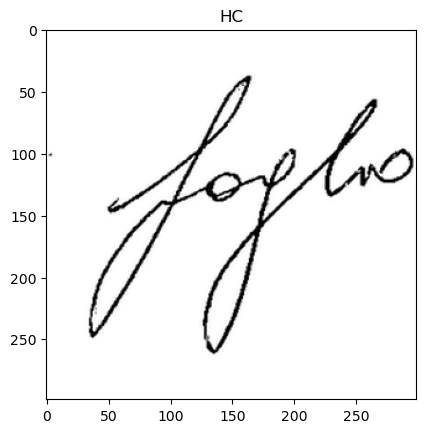

In [5]:
# Display example image
plt.title(label=labels[0])
plt.imshow(image_list[0])

In [6]:
# Image parameters
input_shape = (128, 128, 3)
# Hyperparameters
batch_size = 32
epochs = 10
# Define the number of folds
k = 5
# Initialize the k-fold cross-validator
kf = StratifiedKFold(n_splits=k)

In [7]:
# Load the pre-trained models without the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_base.trainable = False
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet50_base.trainable = False
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenet_base.trainable = False

# Build the traditional CNN model
def build_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build the model using the pre-trained base
def build_model(base_model):
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [8]:
# Build and compile models
cnn_model = build_cnn_model()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg16_model = build_model(vgg16_base)
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

resnet50_model = build_model(resnet50_base)
resnet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

mobilenet_model = build_model(mobilenet_base)
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model
cnn_model.summary()
vgg16_model.summary()
resnet50_model.summary()
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

In [9]:
# preparing data before feed to model
import numpy as np

def preprocess(image_list,labels):
    X = []
    for image in image_list:
        image_rescale = cv2.resize(image,(input_shape[0],input_shape[1]))
        # convert every pixel except from white to black
        image_rescale = cv2.threshold(image_rescale, 128, 255, cv2.THRESH_BINARY)[1]
        X.append(image_rescale)
    X = np.array(X)
    y = np.array([0 if label == 'HC' else 1 for label in labels])
    print('Data_predictor shapes : ',X.shape)
    print('Data_target shapes : ',y.shape)
    
    return X,y

Data_predictor shapes :  (166, 128, 128, 3)
Data_target shapes :  (166,)
Epoch 1/10
21/21 [==============================] - 7s 76ms/step - loss: 59.1892 - accuracy: 0.4742 - val_loss: 0.9080 - val_accuracy: 0.4706
Epoch 2/10
21/21 [==============================] - 1s 35ms/step - loss: 0.7457 - accuracy: 0.5348 - val_loss: 0.8054 - val_accuracy: 0.5294
Epoch 3/10
21/21 [==============================] - 1s 34ms/step - loss: 0.6558 - accuracy: 0.5712 - val_loss: 0.5904 - val_accuracy: 0.7059
Epoch 4/10
21/21 [==============================] - 1s 34ms/step - loss: 0.6307 - accuracy: 0.6182 - val_loss: 0.6555 - val_accuracy: 0.6765
Epoch 5/10
21/21 [==============================] - 1s 34ms/step - loss: 0.5593 - accuracy: 0.7167 - val_loss: 0.6075 - val_accuracy: 0.7941
Epoch 6/10
21/21 [==============================] - 1s 33ms/step - loss: 0.5469 - accuracy: 0.6924 - val_loss: 0.8575 - val_accuracy: 0.7059
Epoch 7/10
21/21 [==============================] - 1s 33ms/step - loss: 0.4561 

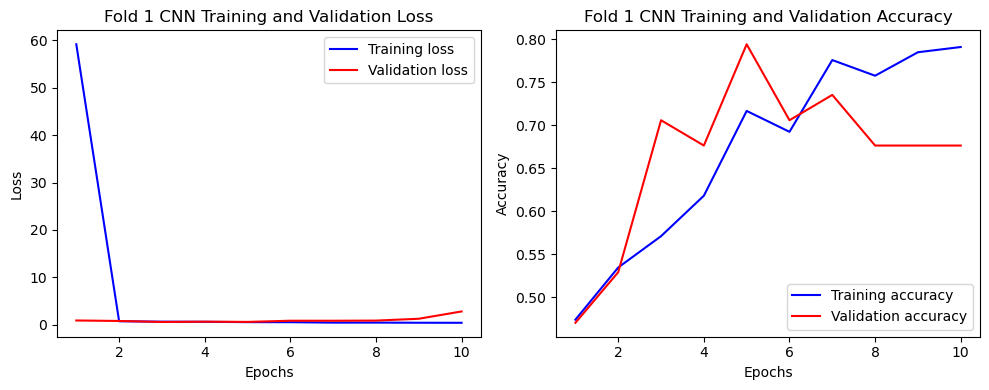

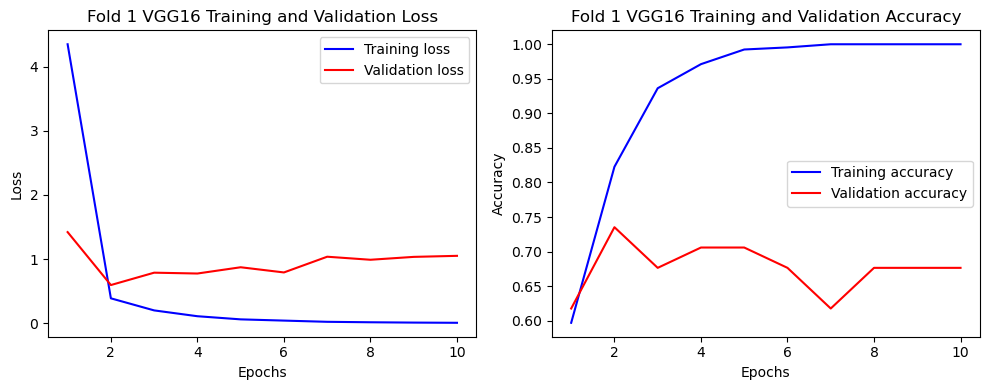

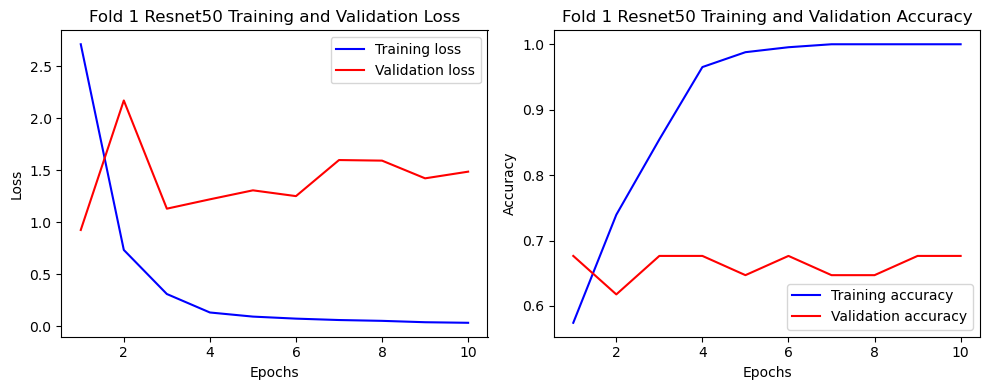

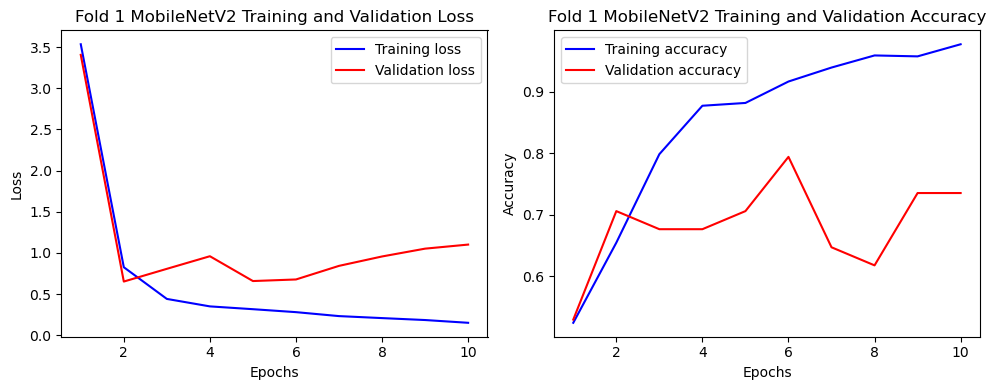

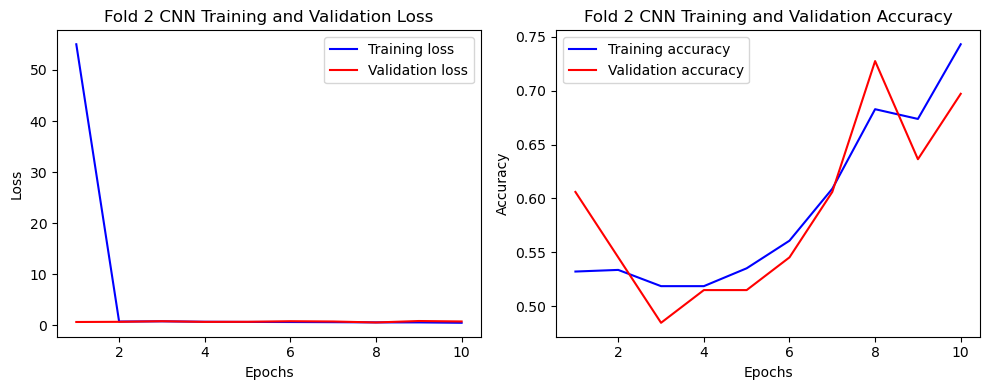

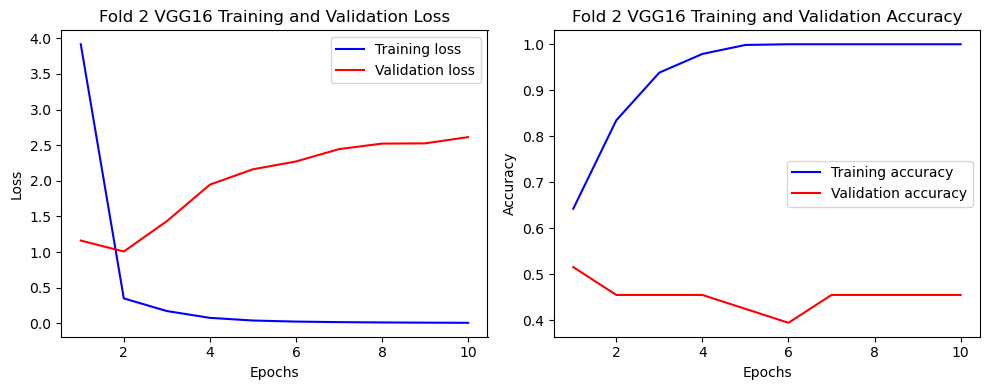

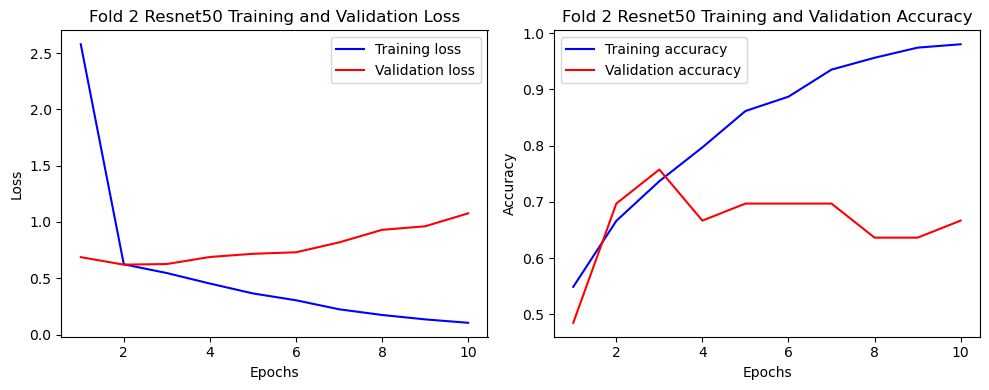

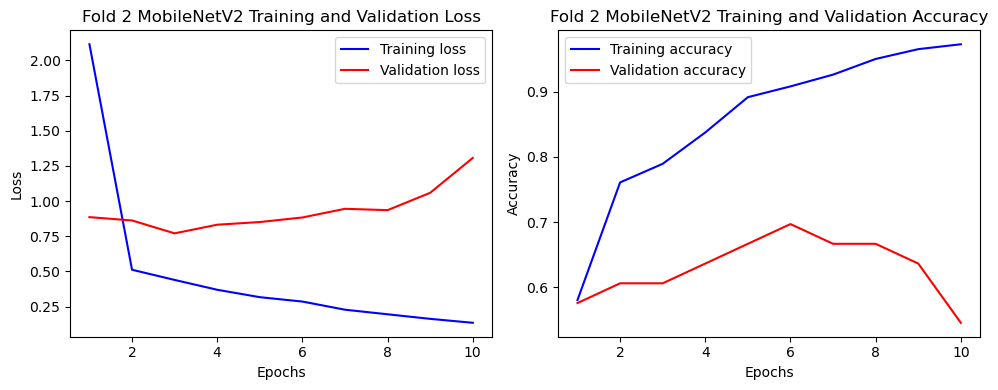

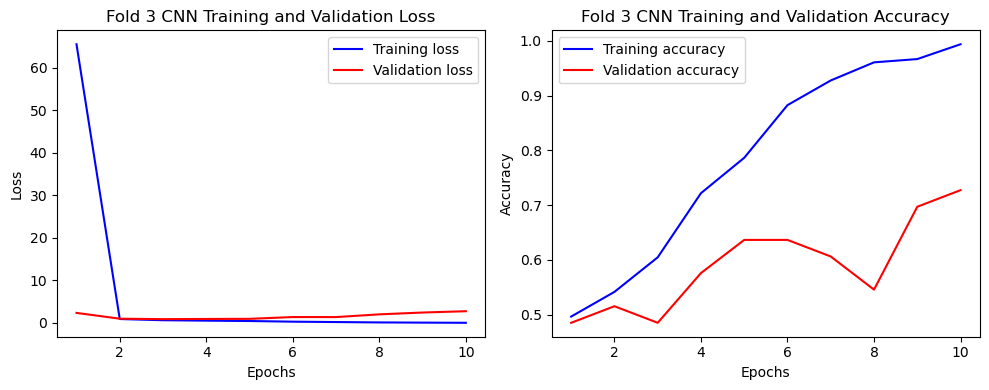

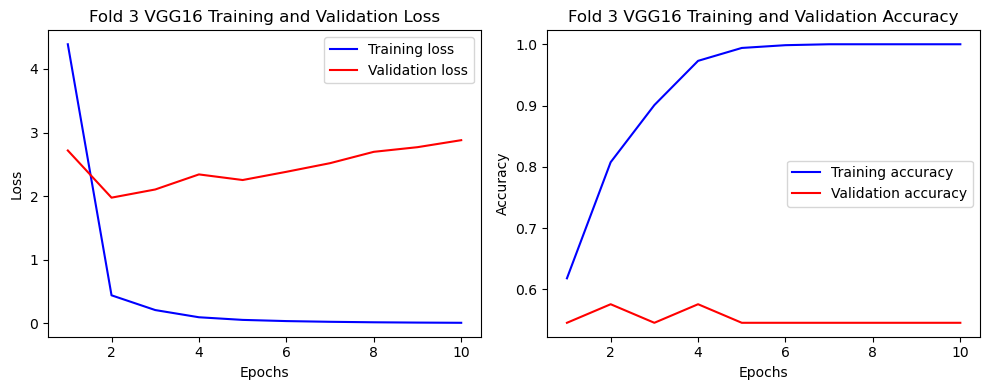

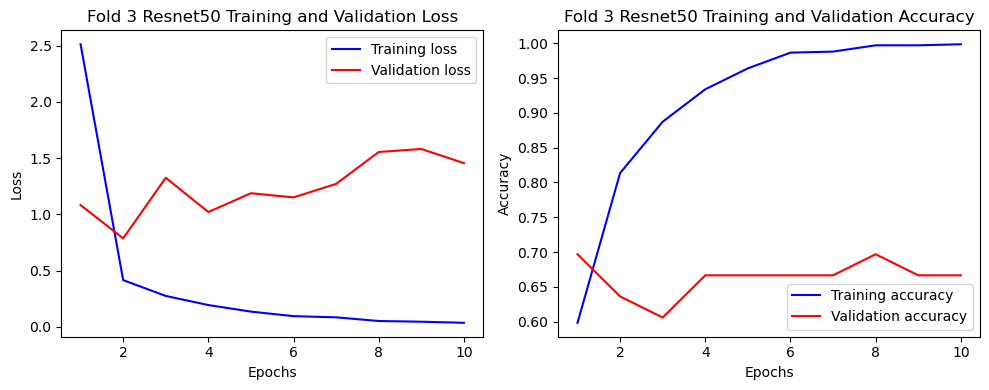

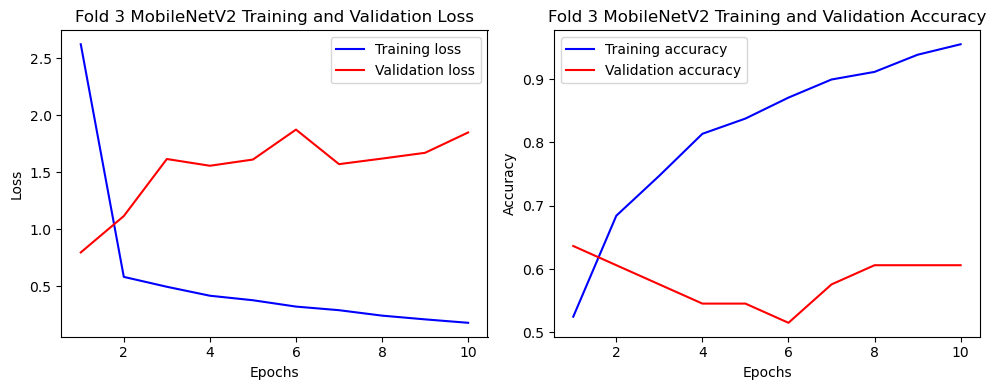

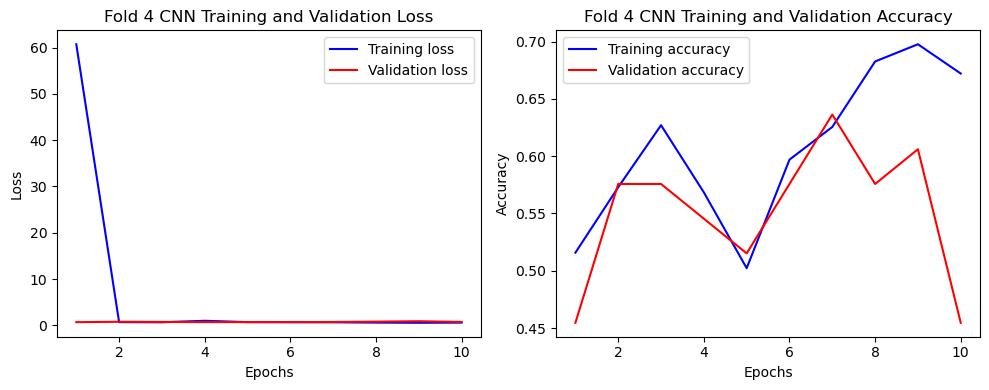

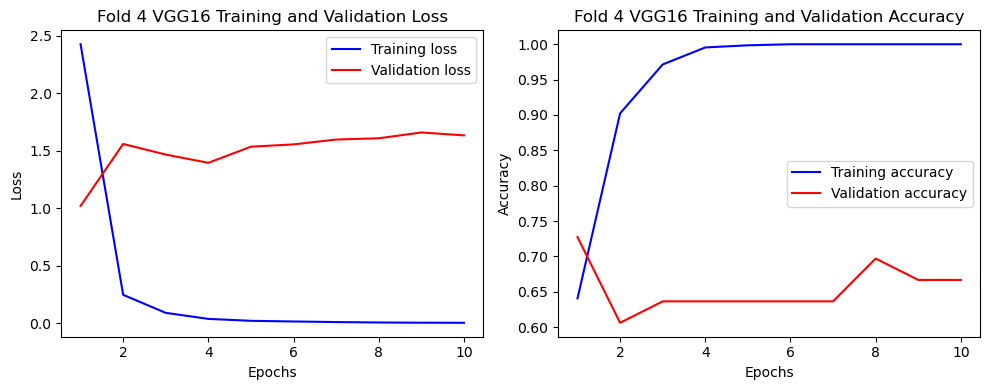

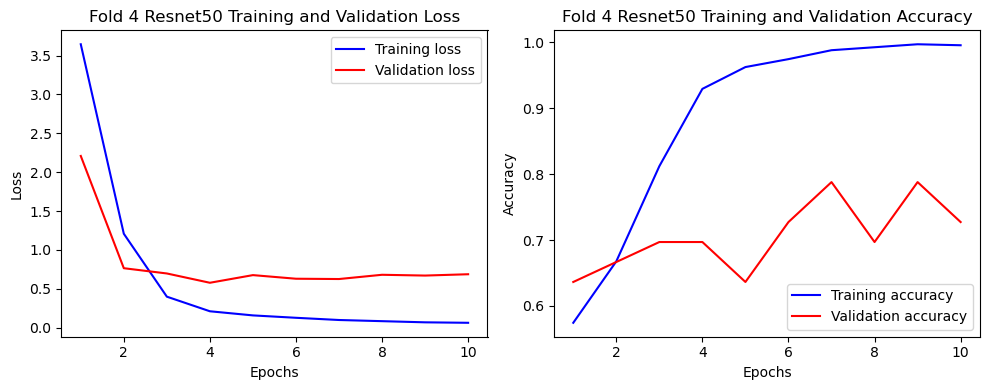

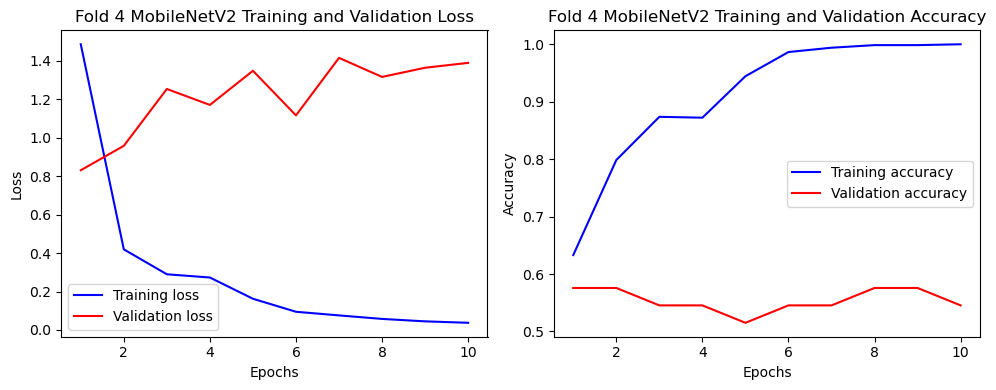

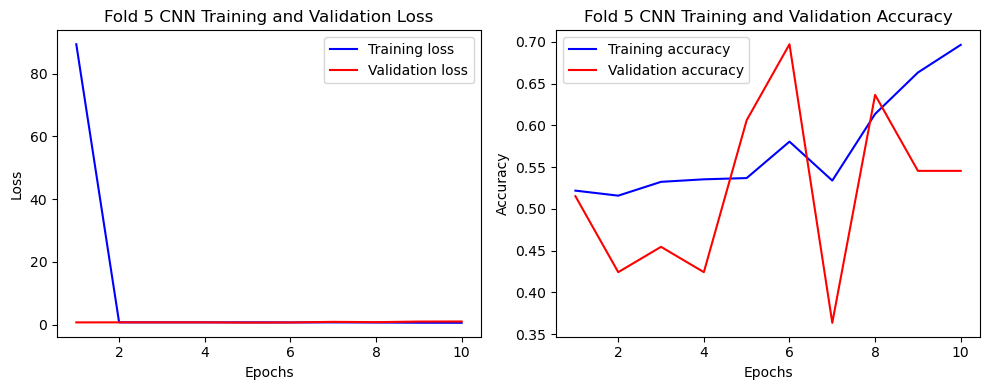

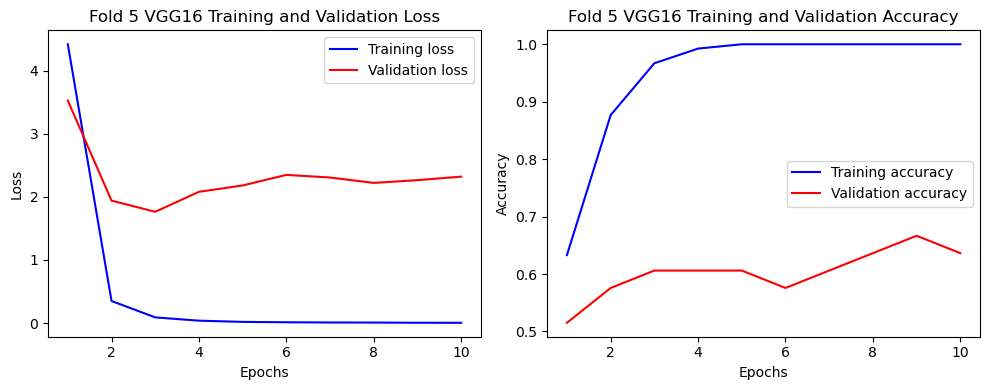

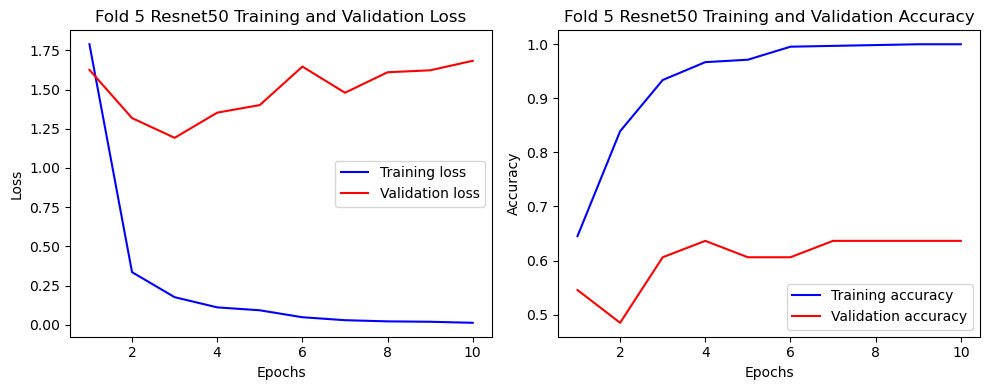

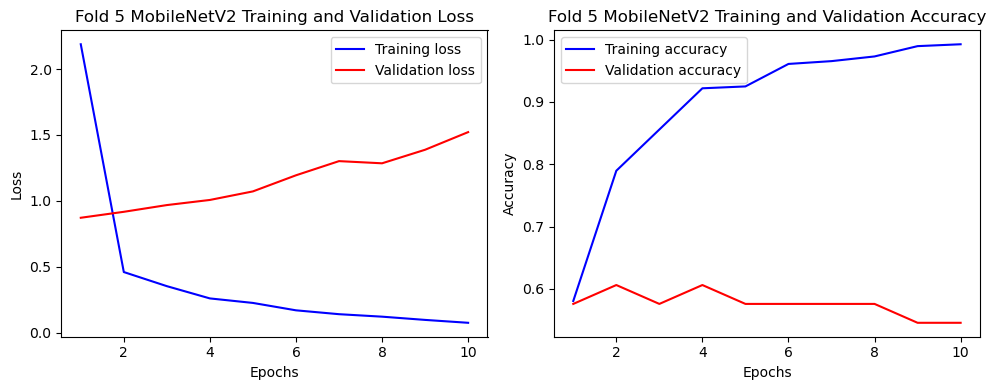

In [10]:
X,y = preprocess(image_list,labels)
fold = 1
df_list = []
# Perform the k-fold cross-validation
for train_index, test_index in kf.split(X, y):
    # Split the data into training and test sets based on the indices
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Generate augmented data by applying transformations to the training data
    augmented_images, augmented_labels = augment_images(X_train, y_train, num_augmentations=5)
    
    # Build models
    cnn_model = build_cnn_model()
    vgg16_model = build_model(vgg16_base)
    resnet50_model = build_model(resnet50_base)
    mobilenet_model = build_model(mobilenet_base)
    
    train_score = {}
    test_score = {}
    for name,model in zip(['CNN','VGG16','Resnet50','MobileNetV2'],[cnn_model,vgg16_model,resnet50_model,mobilenet_model]):
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(augmented_images,augmented_labels,batch_size=batch_size,epochs=epochs,validation_data=(X_test, y_test))
        plot_training_history(history,name,fold,task)
        train_score[name] = accuracy_score(y_train, (model.predict(X_train)>= 0.5).astype(int))
        test_score[name] = accuracy_score(y_test, (model.predict(X_test)>= 0.5).astype(int))
    # Create a DataFrame from the results dictionary
    df_list.append(pd.DataFrame.from_dict(train_score, orient='index', columns=['train_fold'+str(fold)]))
    df_list.append(pd.DataFrame.from_dict(test_score, orient='index', columns=['test_fold'+str(fold)]))
    fold +=1

# Concatenate the list of DataFrames into a single DataFrame
results_df = pd.concat(df_list, axis=1)
results_df['train_avg'] = results_df.iloc[:, 0:len(df_list):2].mean(axis=1)
results_df['train_sd'] = results_df.iloc[:, 0:len(df_list):2].std(axis=1)
results_df['test_avg'] = results_df.iloc[:, 1:len(df_list):2].mean(axis=1)
results_df['test_sd'] = results_df.iloc[:, 1:len(df_list):2].std(axis=1)

In [11]:
# Save the results to a CSV file
results_df.to_csv('Task'+task+'_DL_res.csv')

# Print the final DataFrame
print(results_df[['train_avg','train_sd','test_avg','test_sd']])

             train_avg  train_sd  test_avg   test_sd
CNN           0.650524  0.040946  0.620143  0.115707
VGG16         0.972910  0.013634  0.595900  0.094423
Resnet50      0.888483  0.051381  0.674688  0.033037
MobileNetV2   0.692709  0.050230  0.595544  0.082413


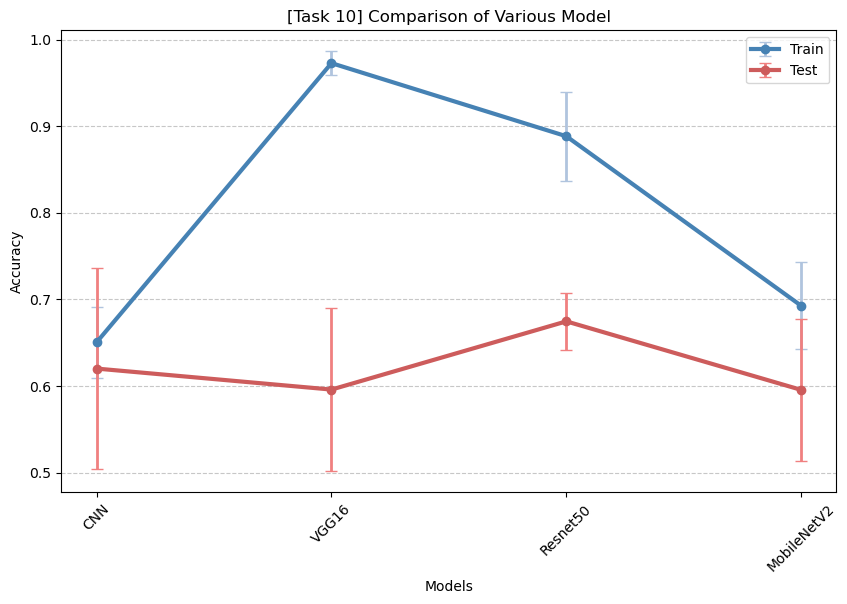

In [12]:
models = results_df.index.tolist()
train_avg = results_df['train_avg']
train_sd = results_df['train_sd']
test_avg = results_df['test_avg']
test_sd = results_df['test_sd']
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot train scores with error bars
plt.errorbar(models, train_avg, yerr=train_sd, label='Train', marker='o', capsize=4,
            color='steelblue', linewidth=3, ecolor='lightsteelblue', elinewidth=2)
plt.errorbar(models, test_avg, yerr=test_sd, label='Test', marker='o', capsize=4,
            color='indianred', linewidth=3, ecolor='lightcoral', elinewidth=2)

# Set labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('[Task 10] Comparison of Various Model')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

plt.savefig('Task'+task+'_res.png', dpi=300)

# Add legend
plt.legend()

# Show the plot
plt.show()
